In [1]:

# libraries to manage number
import numpy as np
import pandas as pd
# libraries to plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# libraries to model

# Libraries to metrics
from sklearn import metrics


# libraries to optimize model
from lmfit import Model

I use the sigmoid function which often works well in epidemiological situations.
The function is as follow: 

$$
    z = \theta_0 + \theta_1*x\\
    g(z) = \frac {1}{(1 + e^{-z})} 
$$

Sigmoid funtion works between 0 and 1, if I do not change the formula, it simply tells us that the end of the event has been reached, through the number 1. For this reason we must multiply the result of the sigmoid function by the maximum number reached by the series


In [2]:
def sigmoid(x, b, r, t):
    z = (t * (b + x))
    sig = 1/(1 + np.exp( -z ))*r
    return sig
#http://www.edscave.com/forecasting---time-series-metrics.html
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')

In [4]:
days = df.loc[df.denominazione_regione=='Lombardia','data'].shape
days = np.arange(days[0])

In [15]:
region_list = df.denominazione_regione.unique()
region_list
df

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2,2020-02-24T18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN
3,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN
4,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,2020-04-05T17:00:00,ITA,9,Toscana,43.769231,11.255889,1111,276,1387,3798,5185,131,176,337,325,5847,51006,NaN,NaN
878,2020-04-05T17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,352,80,432,1363,1795,42,65,273,217,2285,10476,NaN,NaN
879,2020-04-05T17:00:00,ITA,10,Umbria,43.106758,12.388247,159,45,204,694,898,-29,29,298,43,1239,12448,NaN,NaN
880,2020-04-05T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,96,23,119,457,576,16,34,115,91,782,2390,NaN,NaN


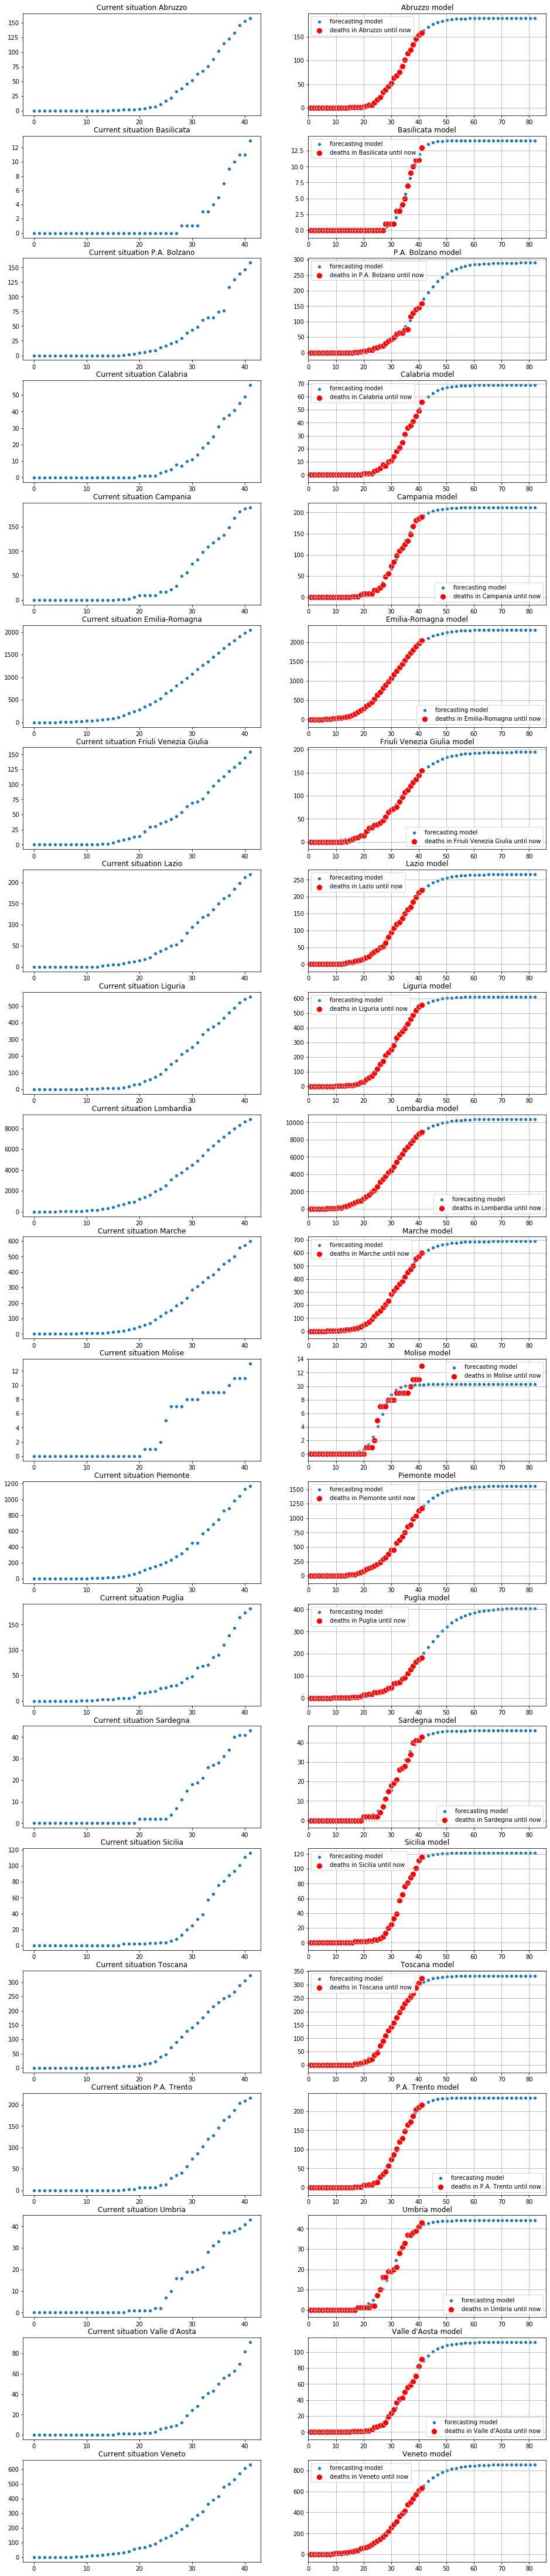

In [6]:
fig, ax = plt.subplots(nrows=21, ncols=2, figsize=(16,80))
n = 0
df_coeff = pd.DataFrame()
for reg in region_list:
    ax[n][0].set_title('Current situation {}'.format(reg))
    sns.scatterplot(x=days, y=df.loc[df.denominazione_regione==reg,'deceduti'].values,ax=ax[n][0])
    x = days
    y = df.loc[df.denominazione_regione==reg,'deceduti'].values
           
    model = Model(sigmoid)
    pred = model.fit(y, x=x, b= 0, r=y.max()/2, t= 0.001)

    x_ideal = np.linspace(np.min(x), np.max(x)*2)
    ideal = pred.eval(x=x_ideal)
    sns.scatterplot(x_ideal, ideal, label='forecasting model', ax=ax[n][1])
    #print(result.fit_report())   # decommenta questa linea per ottenere le metriche

    sns.scatterplot(x=x, y=y, label='deaths in {} until now'.format(reg), s=100, color='red', ax=ax[n][1])

    ax[n][1].grid()
    ax[n][1].set_title('{} model'.format(reg))
    ax[n][1].set_xlim(0)
    
    df_coeff = df_coeff.append(pred.values, ignore_index=True)
    #df_coeff.loc[n, 'MAPE'] = mean_absolute_percentage_error(ideal[:len(y)],y)
    df_coeff.loc[n,'Regions'] = reg
    n+=1

#plt.savefig('plot_fig.png')   
#plt.show()


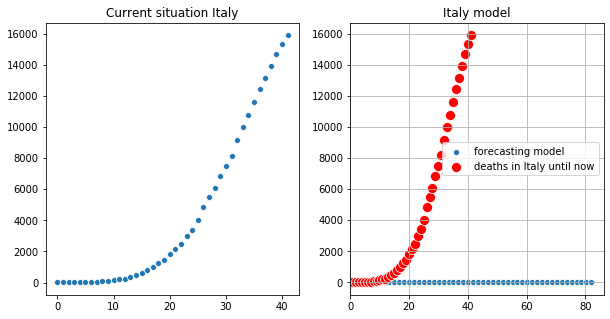

In [18]:
italy = df.groupby('data').sum()

reg='Italy'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].set_title('Current situation {}'.format(reg))
sns.scatterplot(x=days, y=italy['deceduti'].values,ax=ax[0])
x = days
y = italy['deceduti'].values
        
model = Model(sigmoid)
pred = model.fit([1,2,3,4], x=[1,2,3,4], b= 0, r=y.max()/2, t= 0.001)
x_ideal = np.linspace(np.min(x), np.max(x)*2)
ideal = pred.eval(x=x_ideal)
sns.scatterplot(x_ideal, ideal, label='forecasting model', ax=ax[1])
#print(result.fit_report())   # decommenta questa linea per ottenere le metriche
sns.scatterplot(x=x, y=y, label='deaths in {} until now'.format(reg), s=100, color='red', ax=ax[1])

ax[1].grid()
ax[1].set_title('{} model'.format(reg))
ax[1].set_xlim(0)

df_coeff = df_coeff.append(pred.values, ignore_index=True)
#df_coeff.loc[n, 'MAPE'] = mean_absolute_percentage_error(ideal[:len(y)],y)
df_coeff.loc[21,'Regions'] = reg


In [8]:
df_coeff.columns=['beta', 'cap', 'theta', 'Regions']
df_coeff['cap'] = df_coeff['cap'].apply(lambda x: int(x))
df_coeff[['cap','Regions']].rename(columns={'cap':'Assumed number of deaths','Regions':'Regions'})

,Assumed number of deaths,Regions
0,189,Abruzzo
1,14,Basilicata
2,290,P.A. Bolzano
3,68,Calabria
4,211,Campania
5,2329,Emilia-Romagna
6,194,Friuli Venezia Giulia
7,266,Lazio
8,612,Liguria
9,10401,Lombardia


In [9]:
print('Forecasting with regions study: {}'.format(df_coeff.cap[:21].sum()))
print('Forecasting with regions study: {}'.format(df_coeff.cap[21]))

Forecasting with regions study: 18984
Forecasting with regions study: 18990


Between these two approaches there is a difference of 700; some regions, fortunately, have a low number of deaths, but for predictive analysis a low number means a low precision, perhaps the study of the whole nation could be more precise.

In [10]:
from scipy.spatial import ConvexHull
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

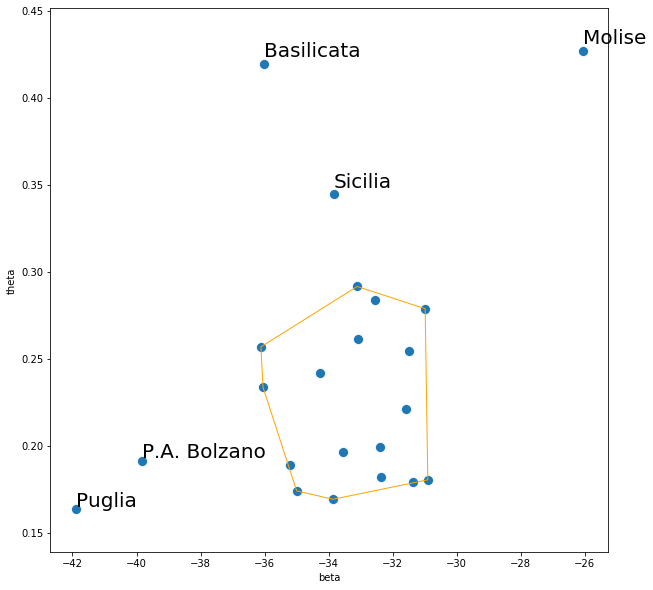

In [11]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_coeff, x='beta', y='theta', s=100)
n = list(np.concatenate( (df_coeff.sort_values('theta', ascending=False).head(3).index.values,df_coeff.sort_values('beta').head(2).index.values), axis=0))
for i in n:
    plt.annotate(df_coeff.Regions[i], (df_coeff.beta[i], df_coeff.theta[i]*1.01),size=20)

N = list(df_coeff.index.values)
N = [x for x in N if x not in n]

encircle(df_coeff[df_coeff.index.isin(N)].beta, df_coeff[df_coeff.index.isin(N)].theta, ec="orange", fc="none")

These 5 regions are outside the group of other, maybe them values are too few to be reliable

In [19]:

model = Model(sigmoid)
pred = model.fit([1,2,3,4], x=[1,2,3,4], b= 0, r=y.max()/2, t= 0.001)

In [20]:

model = Model(sigmoid)
pred = model.fit([1,2,3,4], x=[1,2,3,4], b= 0, r=y.max()/2, t= 0.001)

In [21]:
['Algeria', 'Canada', 'Poland', 'Mexico', 'Russia', 'Germany',
 'France', 'United Kingdom', 'Iran', 'China', 'Netherlands', 'Denmark']
       

['Italy',
 'Spain',
 'US',
 'Germany',
 'Belgium',
 'Switzerland',
 'Turkey',
 'Brazil',
 'Sweden',
 'Portugal',
 'Indonesia',
 'Austria',
 'Korea, South',
 'Ecuador',
 'Romania']

In [22]:
['Philippines', 'Ireland', 'India','Japan', 'Peru', 'Egypt', 'Greece', 'Dominican Republic', 'Norway', 'Czechia', 'Morocco', 'Malaysia', 'Iraq',
       'Israel', 'Serbia']

IndentationError: unexpected indent (<ipython-input-22-5f148e193055>, line 2)

In [ ]:
, 'Algeria', 'Canada', 'Poland', 'Mexico', 'Russia'